In [1]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [3]:
data=pd.read_csv("tpm_data.csv", header=0)
data

,Unnamed: 0,ENSG,hgnc_symbol,gene_length,C_0002,C_0003,C_0004,C_0005,C_0006,C_0008,...,H_0740,H_0750,H_0513,H_0601,H_0656,H_0689,H_0709,H_0723,H_1104,H_1105
0,1,ENSG00000000003,TSPAN6,12883,2.703162,4.679815,3.827170,3.940771,3.956139,4.749555,...,4.799810,8.733498,3.666497,4.563176,2.492904,2.949728,3.314066,6.985665,3.947979,3.784485
1,2,ENSG00000000005,TNMD,14949,0.005418,0.029438,0.088121,0.036995,0.053272,0.108531,...,0.024476,0.086370,0.083015,0.078651,0.050749,0.014444,0.028001,0.138079,0.031214,0.064583
2,3,ENSG00000000419,DPM1,24273,2.625862,4.387499,4.450224,5.390720,3.707350,5.356800,...,4.100151,6.470481,5.783705,6.878268,3.167153,1.530000,6.380522,8.912018,6.420788,9.267549
3,4,ENSG00000000457,SCYL3,44636,0.896318,1.025353,1.568379,1.315815,1.617599,1.350063,...,0.610696,0.892573,1.098204,1.589228,0.708180,0.416006,0.628301,1.156094,1.317197,2.011547
4,5,ENSG00000000460,C1orf112,192073,0.033732,0.123724,0.065645,0.074862,0.063574,0.114637,...,0.030003,0.052817,0.036344,0.091820,0.025015,0.042717,0.034868,0.060181,0.072882,0.070371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21858,26560,ENSG00000273372,SFTPD-AS1,5000,0.680299,0.616103,0.715117,1.061834,1.061811,1.437003,...,0.311009,0.202893,0.201662,1.018982,0.050577,0.647750,0.000000,0.247696,0.559947,0.096546
21859,26565,ENSG00000273396,LINC01396,6639,0.036596,0.066286,0.226767,0.049981,0.119952,0.139644,...,0.013778,0.027783,0.000000,0.000000,0.038090,0.000000,0.000000,0.000000,0.000000,0.000000
21860,26570,ENSG00000273409,LINC02712,66004,0.019632,0.040004,0.068428,0.016758,0.036196,0.017558,...,0.005544,0.027945,0.054055,0.065315,0.015325,0.009814,0.000000,0.012509,0.028278,0.058509
21861,26571,ENSG00000273415,LINC02725,87913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
dataX_pre=data.iloc[:,4:]
dataX=dataX_pre.T
dataX_min=np.min(dataX.values[dataX.values>0])
dataX_min

8.621517048846005e-05

In [5]:
#convert 0 into minimized number which cannot affect analysis
convert_num = 8.621517048846005e-06
dataX[dataX== 0] = convert_num

In [6]:
dataX_copy=dataX.copy()
dataX_copy_log=dataX_copy.apply(np.log)

In [7]:
#delete a column which has a smallest std (deleting LINC02694)
dataX_after_del=dataX_copy.drop(dataX_copy.columns[13609],axis=1)
dataX_after_del

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,2.703162,0.005418,2.625862,0.896318,0.033732,1.520210,0.668186,2.390171,1.079804,1.846578,...,1.024701,0.000009,0.007266,12.989309,2.596021,0.680299,0.036596,0.019632,0.000009,0.417913
C_0003,4.679815,0.029438,4.387499,1.025353,0.123724,2.417254,0.541779,6.715102,2.762668,5.757188,...,3.380591,0.400795,0.000009,42.426011,2.992243,0.616103,0.066286,0.040004,0.000009,0.416324
C_0004,3.827170,0.088121,4.450224,1.568379,0.065645,1.855760,0.840779,4.118158,1.709962,3.075835,...,1.955870,0.171392,0.008442,24.410100,2.010758,0.715117,0.226767,0.068428,0.000009,0.716177
C_0005,3.940771,0.036995,5.390720,1.315815,0.074862,1.803517,1.254086,5.239934,2.649874,4.998753,...,3.698587,0.201471,0.000009,24.525642,3.975217,1.061834,0.049981,0.016758,0.000009,0.516058
C_0006,3.956139,0.053272,3.707350,1.617599,0.063574,1.354761,0.569268,4.474453,2.367638,4.753598,...,0.719709,0.000009,0.000009,33.152522,1.418155,1.061811,0.119952,0.036196,0.000009,0.388106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,2.949728,0.014444,1.530000,0.416006,0.042717,4.108964,1.871441,2.094295,0.747223,2.215735,...,0.487837,0.196645,0.009686,9.461733,2.411892,0.647750,0.000009,0.009814,0.000009,0.102132
H_0709,3.314066,0.028001,6.380522,0.628301,0.034868,1.158647,0.860249,3.787714,1.060191,1.706804,...,0.945729,0.000009,0.000009,31.182523,3.252682,0.000009,0.000009,0.000009,0.000009,0.890978
H_0723,6.985665,0.138079,8.912018,1.156094,0.060181,1.946203,1.799320,4.370479,1.842778,3.689338,...,2.425103,1.503924,0.018520,57.708965,6.215465,0.247696,0.000009,0.012509,0.000009,0.781096
H_1104,3.947979,0.031214,6.420788,1.317197,0.072882,2.361264,1.357402,3.256530,1.497821,3.361442,...,2.319405,0.000009,0.000009,24.742013,3.172758,0.559947,0.000009,0.028278,0.000009,0.642094


In [8]:
#delete a column which has a smallest std
dataX_after_del2=dataX_after_del.drop(dataX_copy.columns[19081],axis=1)
dataX_after_del2

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,2.703162,0.005418,2.625862,0.896318,0.033732,1.520210,0.668186,2.390171,1.079804,1.846578,...,1.024701,0.000009,0.007266,12.989309,2.596021,0.680299,0.036596,0.019632,0.000009,0.417913
C_0003,4.679815,0.029438,4.387499,1.025353,0.123724,2.417254,0.541779,6.715102,2.762668,5.757188,...,3.380591,0.400795,0.000009,42.426011,2.992243,0.616103,0.066286,0.040004,0.000009,0.416324
C_0004,3.827170,0.088121,4.450224,1.568379,0.065645,1.855760,0.840779,4.118158,1.709962,3.075835,...,1.955870,0.171392,0.008442,24.410100,2.010758,0.715117,0.226767,0.068428,0.000009,0.716177
C_0005,3.940771,0.036995,5.390720,1.315815,0.074862,1.803517,1.254086,5.239934,2.649874,4.998753,...,3.698587,0.201471,0.000009,24.525642,3.975217,1.061834,0.049981,0.016758,0.000009,0.516058
C_0006,3.956139,0.053272,3.707350,1.617599,0.063574,1.354761,0.569268,4.474453,2.367638,4.753598,...,0.719709,0.000009,0.000009,33.152522,1.418155,1.061811,0.119952,0.036196,0.000009,0.388106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,2.949728,0.014444,1.530000,0.416006,0.042717,4.108964,1.871441,2.094295,0.747223,2.215735,...,0.487837,0.196645,0.009686,9.461733,2.411892,0.647750,0.000009,0.009814,0.000009,0.102132
H_0709,3.314066,0.028001,6.380522,0.628301,0.034868,1.158647,0.860249,3.787714,1.060191,1.706804,...,0.945729,0.000009,0.000009,31.182523,3.252682,0.000009,0.000009,0.000009,0.000009,0.890978
H_0723,6.985665,0.138079,8.912018,1.156094,0.060181,1.946203,1.799320,4.370479,1.842778,3.689338,...,2.425103,1.503924,0.018520,57.708965,6.215465,0.247696,0.000009,0.012509,0.000009,0.781096
H_1104,3.947979,0.031214,6.420788,1.317197,0.072882,2.361264,1.357402,3.256530,1.497821,3.361442,...,2.319405,0.000009,0.000009,24.742013,3.172758,0.559947,0.000009,0.028278,0.000009,0.642094


In [9]:
#log conversion of Dataframe
dataX_log_del2=dataX_after_del2.apply(np.log)
dataX_log_del2

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,0.994422,-5.218099,0.965409,-0.109460,-3.389303,0.418849,-0.403189,0.871365,0.076779,0.613334,...,0.024401,-11.661249,-4.924490,2.564127,0.953980,-0.385223,-3.307803,-3.930581,-11.661249,-0.872483
C_0003,1.543259,-3.525458,1.478759,0.025037,-2.089705,0.882632,-0.612896,1.904359,1.016197,1.750449,...,1.218051,-0.914304,-11.661249,3.747762,1.096023,-0.484341,-2.713775,-3.218770,-11.661249,-0.876291
C_0004,1.342126,-2.429044,1.492955,0.450043,-2.723493,0.618294,-0.173427,1.415406,0.536471,1.123576,...,0.670835,-1.763801,-4.774493,3.194997,0.698512,-0.335309,-1.483830,-2.681972,-11.661249,-0.333828
C_0005,1.371376,-3.296972,1.684679,0.274456,-2.592106,0.589739,0.226407,1.656309,0.974512,1.609188,...,1.307951,-1.602108,-11.661249,3.199719,1.380079,0.059998,-2.996114,-4.088895,-11.661249,-0.661535
C_0006,1.375269,-2.932350,1.310317,0.480943,-2.755552,0.303625,-0.563404,1.498384,0.861893,1.558902,...,-0.328908,-11.661249,-11.661249,3.501119,0.349357,0.059976,-2.120667,-3.318809,-11.661249,-0.946478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,1.081713,-4.237507,0.425267,-0.877056,-3.153152,1.413171,0.626709,0.739217,-0.291392,0.795584,...,-0.717774,-1.626353,-4.637045,2.247256,0.880411,-0.434250,-11.661249,-4.623965,-11.661249,-2.281487
H_0709,1.198176,-3.575533,1.853250,-0.464737,-3.356175,0.147253,-0.150534,1.331763,0.058449,0.534623,...,-0.055800,-11.661249,-11.661249,3.439858,1.179480,-11.661249,-11.661249,-11.661249,-11.661249,-0.115436
H_0723,1.943860,-1.979933,2.187401,0.145047,-2.810397,0.665880,0.587409,1.474873,0.611274,1.305447,...,0.885874,0.408078,-3.988909,4.055413,1.827040,-1.395552,-11.661249,-4.381294,-11.661249,-0.247057
H_1104,1.373204,-3.466880,1.859541,0.275506,-2.618914,0.859197,0.305573,1.180662,0.404012,1.212370,...,0.841311,-11.661249,-11.661249,3.208503,1.154601,-0.579914,-11.661249,-3.565657,-11.661249,-0.443020


In [10]:
featuresToScale=dataX_log_del2.columns
sX=pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX_log_del2.loc[:, featuresToScale]=sX.fit_transform(dataX_log_del2)

In [11]:
dataX_C=dataX_log_del2.filter(like='C', axis=0)
dataX_C

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,-1.238669,-0.489755,-1.404819,-0.661768,-1.214104,-0.438326,-0.542205,-1.549951,-1.144974,-1.361823,...,-0.794664,-1.270403,0.737597,-1.819190,-0.178338,0.264969,0.721004,-0.094753,-0.349492,-0.142859
C_0003,-0.094326,0.128294,-0.400562,-0.392906,0.908731,0.454217,-0.792399,0.733360,0.611638,0.953743,...,0.767006,0.814752,-1.029937,0.719449,0.054000,0.220818,0.859050,0.298774,-0.349492,-0.149023
C_0004,-0.513695,0.528638,-0.372793,0.456696,-0.126533,-0.054497,-0.268084,-0.347413,-0.285398,-0.322790,...,0.051075,0.649930,0.776952,-0.466111,-0.596202,0.287203,1.144874,0.595544,-0.349492,0.728854
C_0005,-0.452707,0.211724,0.002274,0.105692,0.088081,-0.109452,0.208944,0.185074,0.533692,0.666086,...,0.884624,0.681302,-1.029937,-0.455983,0.518626,0.463286,0.793437,-0.182278,-0.349492,0.198520
C_0006,-0.444591,0.344861,-0.730082,0.518467,-0.178900,-0.660072,-0.733352,-0.164000,0.323106,0.563685,...,-1.256904,-1.270403,-1.029937,0.190454,-1.167309,0.463277,0.996881,0.243467,-0.349492,-0.262606
C_0008,-0.063484,0.604704,-0.010074,0.157058,0.784126,0.523687,0.705062,0.107073,0.650657,0.591910,...,0.626894,0.690349,-1.029937,-0.004865,0.357423,0.598058,1.032206,-0.156499,-0.349492,-0.711918
C_0009,-1.014420,0.027920,0.485191,1.511839,2.342554,-0.059718,-0.901242,2.952803,3.037081,1.972919,...,0.056384,1.073685,-1.029937,2.372708,1.781837,-4.757775,-1.220236,1.391432,-0.349492,-3.818267
C_0010,-1.071431,0.484398,-0.933368,-0.658817,-0.998986,-0.943378,-1.362364,-0.970939,-0.853908,-0.605820,...,-0.555258,-1.270403,0.785608,-0.303165,0.070641,0.277815,0.669304,0.071529,-0.349492,-0.462936
C_0011,-0.921800,0.182561,-2.304816,-1.383902,-1.199928,-0.621190,-1.538195,-1.155816,-0.558486,-0.865617,...,-1.144206,-1.270403,-1.029937,-1.399549,-1.752028,-0.121130,0.774877,0.128418,-0.349492,-0.916628
C_0012,0.370489,0.568469,0.573826,1.847973,2.247641,-1.047992,-1.840582,2.485153,2.363211,2.430353,...,1.381163,0.671095,0.987434,1.425060,0.034088,0.766789,0.848066,0.465206,-0.349492,0.968155


In [12]:
dataX_C['cluster']=1
dataX_P=dataX_log_del2.filter(like='P', axis=0)
dataX_P['cluster']=0
dataX_H=dataX_log_del2.filter(like='H',axis=0)
dataX_H['cluster']=2

/tmp/ipykernel_2241646/805336276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX_C['cluster']=1
/tmp/ipykernel_2241646/805336276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX_P['cluster']=0
/tmp/ipykernel_2241646/805336276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [13]:
dataX_cluster=pd.concat([dataX_C, dataX_P, dataX_H], ignore_index=False)
dataX_cluster

,0,1,2,3,4,5,6,7,8,9,...,21854,21855,21856,21857,21858,21859,21860,21861,21862,cluster
C_0002,-1.238669,-0.489755,-1.404819,-0.661768,-1.214104,-0.438326,-0.542205,-1.549951,-1.144974,-1.361823,...,-1.270403,0.737597,-1.819190,-0.178338,0.264969,0.721004,-0.094753,-0.349492,-0.142859,1
C_0003,-0.094326,0.128294,-0.400562,-0.392906,0.908731,0.454217,-0.792399,0.733360,0.611638,0.953743,...,0.814752,-1.029937,0.719449,0.054000,0.220818,0.859050,0.298774,-0.349492,-0.149023,1
C_0004,-0.513695,0.528638,-0.372793,0.456696,-0.126533,-0.054497,-0.268084,-0.347413,-0.285398,-0.322790,...,0.649930,0.776952,-0.466111,-0.596202,0.287203,1.144874,0.595544,-0.349492,0.728854,1
C_0005,-0.452707,0.211724,0.002274,0.105692,0.088081,-0.109452,0.208944,0.185074,0.533692,0.666086,...,0.681302,-1.029937,-0.455983,0.518626,0.463286,0.793437,-0.182278,-0.349492,0.198520,1
C_0006,-0.444591,0.344861,-0.730082,0.518467,-0.178900,-0.660072,-0.733352,-0.164000,0.323106,0.563685,...,-1.270403,-1.029937,0.190454,-1.167309,0.463277,0.996881,0.243467,-0.349492,-0.262606,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,-1.056665,-0.131702,-2.461487,-2.196218,-0.828361,1.475229,0.686531,-1.842048,-1.833416,-0.990698,...,0.676598,0.813014,-2.498809,-0.298672,0.243131,-1.220236,-0.478093,-0.349492,-2.423072,2
H_0709,-0.813836,0.110010,0.332046,-1.371978,-1.159991,-0.961007,-0.240771,-0.532297,-1.179250,-1.522107,...,-1.270403,-1.029937,0.059062,0.190509,-4.757775,-1.220236,-4.368677,-0.349492,1.082281,2
H_0723,0.740941,0.692626,0.985739,-0.153001,-0.268487,0.037081,0.639643,-0.215969,-0.145524,0.047562,...,1.071325,0.983066,1.379293,1.249711,-0.185067,-1.220236,-0.343931,-0.349492,0.869277,2
H_1104,-0.448897,0.149684,0.344353,0.107790,0.044293,0.409116,0.303394,-0.866286,-0.533084,-0.141975,...,-1.270403,-1.029937,-0.437144,0.149815,0.178247,-1.220236,0.106997,-0.349492,0.552147,2


In [14]:
dataX_log_del2

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,-1.238669,-0.489755,-1.404819,-0.661768,-1.214104,-0.438326,-0.542205,-1.549951,-1.144974,-1.361823,...,-0.794664,-1.270403,0.737597,-1.819190,-0.178338,0.264969,0.721004,-0.094753,-0.349492,-0.142859
C_0003,-0.094326,0.128294,-0.400562,-0.392906,0.908731,0.454217,-0.792399,0.733360,0.611638,0.953743,...,0.767006,0.814752,-1.029937,0.719449,0.054000,0.220818,0.859050,0.298774,-0.349492,-0.149023
C_0004,-0.513695,0.528638,-0.372793,0.456696,-0.126533,-0.054497,-0.268084,-0.347413,-0.285398,-0.322790,...,0.051075,0.649930,0.776952,-0.466111,-0.596202,0.287203,1.144874,0.595544,-0.349492,0.728854
C_0005,-0.452707,0.211724,0.002274,0.105692,0.088081,-0.109452,0.208944,0.185074,0.533692,0.666086,...,0.884624,0.681302,-1.029937,-0.455983,0.518626,0.463286,0.793437,-0.182278,-0.349492,0.198520
C_0006,-0.444591,0.344861,-0.730082,0.518467,-0.178900,-0.660072,-0.733352,-0.164000,0.323106,0.563685,...,-1.256904,-1.270403,-1.029937,0.190454,-1.167309,0.463277,0.996881,0.243467,-0.349492,-0.262606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,-1.056665,-0.131702,-2.461487,-2.196218,-0.828361,1.475229,0.686531,-1.842048,-1.833416,-0.990698,...,-1.765663,0.676598,0.813014,-2.498809,-0.298672,0.243131,-1.220236,-0.478093,-0.349492,-2.423072
H_0709,-0.813836,0.110010,0.332046,-1.371978,-1.159991,-0.961007,-0.240771,-0.532297,-1.179250,-1.522107,...,-0.899592,-1.270403,-1.029937,0.059062,0.190509,-4.757775,-1.220236,-4.368677,-0.349492,1.082281
H_0723,0.740941,0.692626,0.985739,-0.153001,-0.268487,0.037081,0.639643,-0.215969,-0.145524,0.047562,...,0.332414,1.071325,0.983066,1.379293,1.249711,-0.185067,-1.220236,-0.343931,-0.349492,0.869277
H_1104,-0.448897,0.149684,0.344353,0.107790,0.044293,0.409116,0.303394,-0.866286,-0.533084,-0.141975,...,0.274111,-1.270403,-1.029937,-0.437144,0.149815,0.178247,-1.220236,0.106997,-0.349492,0.552147


In [15]:
patient_num=dataX_cluster['cluster']
patient_num_array=patient_num.values
patient_num_array

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
#train_patient_num, test_patient_num=train_test_split(patient_num_array, test_size=0.05, random_state=2022)

In [17]:
#X_train_del2,X_test_del2=train_test_split(dataX_log_del2,test_size=0.05,random_state=2022)

In [18]:
X_train, X_test = train_test_split(dataX_cluster, test_size=0.05,random_state=2022)

In [19]:
def corre_plot(X_train, X_train_pred, X_test, X_test_pred):
    x=np.linspace(-2,10)
    y=x
    plt.figure(constrained_layout=True)
    plt.subplot(2,2,1)
    plt.title('train correlation')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,2)
    plt.title('test correlation')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,3)
    plt.title('train correlation narrow')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,4)
    plt.title('test correlation narrow')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.show()

In [20]:
def history_plot(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','eval'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','eval'],loc='upper right')
    plt.show()

In [21]:
def plot_feature_importance(df): 
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values             
    plt.yticks(np.arange(n_features), cols_plot)      
    plt.xlabel('Feature importance')                  
    plt.ylabel('Feature') 

In [22]:
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Input, Lambda
from keras.models import load_model

2025-05-29 19:13:45.329448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [23]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        tf.config.set_soft_device_placement(True)
        growth = tf.config.experimental.get_memory_growth(device)
        print('{} memory growth: {}'.format(device, growth))
else:
    print("Not enough GPU hardware devices available.")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True


2025-05-29 19:13:46.514268: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-05-29 19:13:46.515316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-05-29 19:13:46.527121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-29 19:13:46.527777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2025-05-29 19:13:46.527855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-0

In [24]:
def corre_plot(X_train, X_train_pred, X_test, X_test_pred):
    x=np.linspace(-2,10)
    y=x
    plt.figure(constrained_layout=True)
    plt.subplot(2,2,1)
    plt.title('train correlation')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,2)
    plt.title('test correlation')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,3)
    plt.title('train correlation narrow')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,4)
    plt.title('test correlation narrow')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.show()

In [25]:
def history_plot(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','eval'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','eval'],loc='upper right')
    plt.show()

In [26]:
def plot_feature_importance(df): 
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values             
    plt.yticks(np.arange(n_features), cols_plot)      
    plt.xlabel('Feature importance')                  
    plt.ylabel('Feature') 

In [27]:
model10dims = load_model("model10_11_10dim.h5")
model10dims.summary()

2025-05-29 19:13:56.270673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-29 19:13:56.271844: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-05-29 19:13:56.375965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-29 19:13:56.376724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2025-05-29 19:13

Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_908 (Dense)            (None, 100)               2186200   
_________________________________________________________________
batch_normalization_688 (Bat (None, 100)               400       
_________________________________________________________________
dense_909 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_689 (Bat (None, 100)               400       
_________________________________________________________________
dense_910 (Dense)            (None, 10)                1010      
_________________________________________________________________
batch_normalization_690 (Bat (None, 10)                40        
_________________________________________________________________
dense_911 (Dense)            (None, 100)            

In [28]:
df_train = X_train.iloc[:, :-1]
df_test = X_test.iloc[:, :-1]

In [29]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0083,0.388913,0.232071,1.041605,0.902932,0.923106,-1.479170,-0.725972,0.561737,1.005341,0.631400,...,0.753887,0.656740,-1.029937,0.344238,-0.614887,0.347417,-1.220236,0.130942,3.000866,0.672039
P_0014,-0.491357,-0.208702,-0.949570,-0.080523,0.650120,-0.477062,0.117402,-0.177543,-0.005107,0.238695,...,-0.227848,-1.270403,-1.029937,-0.623604,0.379853,0.394208,0.644572,0.454151,-0.349492,-1.281494
H_0006,1.007862,0.051293,0.647164,-0.520091,0.337481,1.187124,0.750467,-0.115304,-0.631415,-0.789085,...,-0.340969,0.852506,1.126368,0.267152,0.448367,-0.559285,-1.220236,0.912924,-0.349492,1.014469
C_0008,-0.063484,0.604704,-0.010074,0.157058,0.784126,0.523687,0.705062,0.107073,0.650657,0.591910,...,0.626894,0.690349,-1.029937,-0.004865,0.357423,0.598058,1.032206,-0.156499,-0.349492,-0.711918
P_0132,-0.379078,-0.063351,-0.422360,-1.034857,-0.855160,0.566042,-0.034787,-0.017356,-0.152592,-1.035450,...,-1.987399,0.712918,1.102537,0.679585,0.828777,-0.162848,-1.220236,0.291017,-0.349492,-1.054538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0012,-1.521997,0.067175,-0.349465,-1.227161,-1.159223,0.147176,0.480327,-1.637841,-1.043687,-0.477915,...,0.128161,0.782275,-1.029937,-1.323493,-0.181305,-0.492980,-1.220236,-4.368677,-0.349492,-1.423462
P_0015,-1.501659,-0.015775,-2.043978,-1.415894,-0.616190,-1.331602,-1.422446,-1.490010,-1.171014,-0.957152,...,-1.225591,-1.270403,-1.029937,-1.174205,0.032423,0.012057,-1.220236,-0.143522,-0.349492,-1.608102
C_0087,0.262581,0.557800,0.801761,0.796105,0.392620,-0.952609,0.115493,0.295912,0.798726,0.749829,...,0.412925,-1.270403,0.797906,0.189569,-1.457010,0.273234,0.680197,0.341713,-0.349492,1.079904
C_0050,1.048922,0.577184,1.692505,1.645615,0.750238,-0.066897,-0.130413,1.106432,1.015931,1.764417,...,1.333553,-1.270403,1.216004,0.990117,-0.753045,0.618545,1.050514,0.563625,2.764119,1.325121


In [30]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
P_0063,-0.354154,-0.443490,-0.519781,-0.938225,-0.692398,-1.225452,-0.567080,-0.929789,-0.391042,-0.918295,...,-1.361050,-1.270403,0.770840,-0.650630,0.148355,-0.417226,0.656224,-1.557539,-0.349492,-1.420660
P_0029,-0.495266,0.082892,-1.553595,-1.080348,-0.552315,1.010324,-0.309374,-1.022790,-0.761766,-0.485853,...,-0.872063,-1.270403,-1.029937,-1.033890,-0.783647,-0.293198,0.669075,-0.153178,-0.349492,0.354232
H_0010,0.947469,0.610187,1.167948,1.184255,0.972135,0.467329,1.196569,0.468982,0.605396,0.755573,...,1.017267,0.936328,1.164238,0.185686,-0.605207,0.286310,-1.220236,0.613593,-0.349492,1.488160
C_0025,-0.525737,0.242389,0.106966,0.424007,0.286912,-0.878035,-1.127625,0.521370,0.787054,0.509760,...,-0.186735,0.740892,-1.029937,0.404844,-0.157597,0.652556,1.144599,0.312478,-0.349492,0.480518
C_0070,-1.309004,0.213414,-0.418802,-1.097679,-1.892068,0.063291,0.524590,-1.458774,-2.380129,-1.965949,...,-0.788725,-1.270403,-1.029937,-2.301812,-1.832232,-0.425255,0.830336,-1.228546,-0.349492,-0.297272
C_0039,0.076393,0.369525,0.262198,-0.434926,-0.641064,-0.367527,-0.258453,-0.416765,-0.246040,-0.748481,...,0.543181,-1.270403,1.039146,0.081579,-1.086837,-0.351680,-1.220236,0.517124,-0.349492,-1.052990


In [91]:
X_all_pred=model10dims.predict(dataX_log_del2,verbose=1)

4/4 [==============================] - 0s 4ms/step


pearson's correlation cefficient: 0.9911003576008612


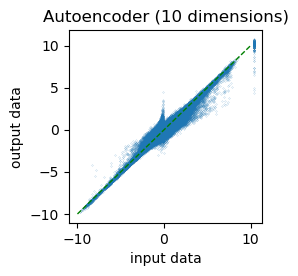

In [99]:
plt.figure(figsize=(2.5,2.5))
plt.scatter(dataX_log_del2.to_numpy().reshape(-1),X_all_pred.reshape(-1), s=0.01)
plt.plot([-10,10],[-10,10], 'g--',linewidth=1.)
plt.title('Autoencoder (10 dimensions)')
plt.xlabel('input data')
plt.ylabel('output data')
print(f"pearson's correlation cefficient: {np.corrcoef(dataX_log_del2.to_numpy().reshape(-1),X_all_pred.reshape(-1))[0,1]}")

In [32]:
def correlation_coefficient(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    return numerator / denominator

In [33]:
corr_coef_test = correlation_coefficient(df_test.values, X_test_pred)
print(corr_coef_test)

0.9872970844075253


In [34]:
corr_coef_tr = correlation_coefficient(df_train.values, X_train_pred)
print(corr_coef_tr)

0.9912588547630568


In [35]:
layer_name = 'dense_910'
latent_layer = Model(inputs = model10dims.input, outputs = model10dims.get_layer(layer_name).output)

In [36]:
latent_layer_pred_train = latent_layer.predict(df_train, verbose=1)

4/4 [==============================] - 0s 2ms/step


In [37]:
latent_layer_pred_train.shape

(102, 10)

In [38]:
latent_layer_pred_test=latent_layer.predict(df_test, verbose=1)

1/1 [==============================] - 0s 17ms/step


In [39]:
latent_layer_pred_test.shape

(6, 10)

In [40]:
X_train_10dims=pd.DataFrame(latent_layer_pred_train)
X_train_10dims

,0,1,2,3,4,5,6,7,8,9
0,6.009770,-0.116596,-3.884397,9.466447,-6.210791,10.363499,-6.480822,-6.431981,8.317493,-10.151834
1,-6.041958,-7.031896,-0.035036,-6.026720,9.640221,-2.293951,2.895993,5.159375,8.464264,-9.648880
2,0.264014,1.035362,-0.534110,5.940433,1.532756,-10.751539,10.312591,-0.970045,-12.190402,14.136766
3,-7.562168,-7.238606,8.801069,-11.129960,0.842867,-9.831837,3.189499,-5.384264,12.091418,-2.478377
4,9.696049,-6.322094,-5.523495,-0.676701,9.112110,-5.423116,0.220518,11.457376,-11.707994,-0.188018
...,...,...,...,...,...,...,...,...,...,...
97,0.426304,-12.922999,0.010505,7.786605,3.437022,13.803056,-1.683597,-2.044187,0.861588,2.002081
98,9.342772,-3.227812,1.095684,3.423271,12.876227,2.455095,3.271398,13.069257,4.655768,4.580972
99,1.916699,12.988074,2.033382,1.448987,-2.773812,10.903077,-11.291394,-11.213188,-5.023474,-8.491025
100,-12.577526,4.521458,9.041041,1.925805,-6.271043,-0.512782,-4.672748,-8.338315,10.902304,7.582399


In [41]:
X_test_10dims=pd.DataFrame(latent_layer_pred_test)
X_test_10dims

,0,1,2,3,4,5,6,7,8,9
0,12.182652,-9.016517,5.416154,4.398924,3.030411,9.104897,-2.629755,-9.648589,-7.168473,1.398691
1,-5.695566,-4.088038,7.612744,-7.422001,11.953300,-1.205127,4.046550,12.574976,0.551326,-0.709395
2,-4.591668,-2.130538,1.383535,12.661238,-14.747499,-0.825547,-0.599415,-2.178931,9.465315,4.564372
3,5.936712,14.305503,-10.923644,4.596941,-2.134693,5.222218,-1.368526,-4.935497,7.297935,-9.517170
4,3.340047,-11.103286,0.380939,-9.910574,5.785901,8.730873,5.895844,0.523430,-10.370501,10.999421
5,8.454951,-5.118403,-11.746635,2.318626,-7.586737,12.236910,7.013754,7.383508,7.247571,-10.797413


In [42]:
X_train_10dims['patient number'] = X_train.iloc[:, -1].values

In [43]:
X_train_10dims

,0,1,2,3,4,5,6,7,8,9,patient number
0,6.009770,-0.116596,-3.884397,9.466447,-6.210791,10.363499,-6.480822,-6.431981,8.317493,-10.151834,1
1,-6.041958,-7.031896,-0.035036,-6.026720,9.640221,-2.293951,2.895993,5.159375,8.464264,-9.648880,0
2,0.264014,1.035362,-0.534110,5.940433,1.532756,-10.751539,10.312591,-0.970045,-12.190402,14.136766,2
3,-7.562168,-7.238606,8.801069,-11.129960,0.842867,-9.831837,3.189499,-5.384264,12.091418,-2.478377,1
4,9.696049,-6.322094,-5.523495,-0.676701,9.112110,-5.423116,0.220518,11.457376,-11.707994,-0.188018,0
...,...,...,...,...,...,...,...,...,...,...,...
97,0.426304,-12.922999,0.010505,7.786605,3.437022,13.803056,-1.683597,-2.044187,0.861588,2.002081,2
98,9.342772,-3.227812,1.095684,3.423271,12.876227,2.455095,3.271398,13.069257,4.655768,4.580972,0
99,1.916699,12.988074,2.033382,1.448987,-2.773812,10.903077,-11.291394,-11.213188,-5.023474,-8.491025,1
100,-12.577526,4.521458,9.041041,1.925805,-6.271043,-0.512782,-4.672748,-8.338315,10.902304,7.582399,1


In [44]:
X_test_10dims['patient number'] = X_test.iloc[:, -1].values

In [45]:
X_test_10dims

,0,1,2,3,4,5,6,7,8,9,patient number
0,12.182652,-9.016517,5.416154,4.398924,3.030411,9.104897,-2.629755,-9.648589,-7.168473,1.398691,0
1,-5.695566,-4.088038,7.612744,-7.422001,11.953300,-1.205127,4.046550,12.574976,0.551326,-0.709395,0
2,-4.591668,-2.130538,1.383535,12.661238,-14.747499,-0.825547,-0.599415,-2.178931,9.465315,4.564372,2
3,5.936712,14.305503,-10.923644,4.596941,-2.134693,5.222218,-1.368526,-4.935497,7.297935,-9.517170,1
4,3.340047,-11.103286,0.380939,-9.910574,5.785901,8.730873,5.895844,0.523430,-10.370501,10.999421,1
5,8.454951,-5.118403,-11.746635,2.318626,-7.586737,12.236910,7.013754,7.383508,7.247571,-10.797413,1


In [46]:
df_10dims=pd.concat([X_train_10dims, X_test_10dims], axis=0, ignore_index=True)
df_10dims

,0,1,2,3,4,5,6,7,8,9,patient number
0,6.009770,-0.116596,-3.884397,9.466447,-6.210791,10.363499,-6.480822,-6.431981,8.317493,-10.151834,1
1,-6.041958,-7.031896,-0.035036,-6.026720,9.640221,-2.293951,2.895993,5.159375,8.464264,-9.648880,0
2,0.264014,1.035362,-0.534110,5.940433,1.532756,-10.751539,10.312591,-0.970045,-12.190402,14.136766,2
3,-7.562168,-7.238606,8.801069,-11.129960,0.842867,-9.831837,3.189499,-5.384264,12.091418,-2.478377,1
4,9.696049,-6.322094,-5.523495,-0.676701,9.112110,-5.423116,0.220518,11.457376,-11.707994,-0.188018,0
...,...,...,...,...,...,...,...,...,...,...,...
103,-5.695566,-4.088038,7.612744,-7.422001,11.953300,-1.205127,4.046550,12.574976,0.551326,-0.709395,0
104,-4.591668,-2.130538,1.383535,12.661238,-14.747499,-0.825547,-0.599415,-2.178931,9.465315,4.564372,2
105,5.936712,14.305503,-10.923644,4.596941,-2.134693,5.222218,-1.368526,-4.935497,7.297935,-9.517170,1
106,3.340047,-11.103286,0.380939,-9.910574,5.785901,8.730873,5.895844,0.523430,-10.370501,10.999421,1


In [47]:
# name columns
df_10dims.columns=['column 1','column 2','column 3','column 4','column 5','column 6','column 7','column 8','column 9','column 10', 'patient number']

In [48]:
X_train_10dims.to_csv('re-latent_df_train_10dims_PD_HD.csv', index = False)
X_test_10dims.to_csv('re-latent_df_test_10dims_PD_HD.csv', index = False)

In [49]:
df_10dims.to_csv('re-latent_df_10dims_PD_HD.csv', index = False)

In [50]:
#importing library
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [51]:
# data split and standardalization
x_gbm = df_10dims.drop('patient number', axis = 1).values
y_gbm = df_10dims['patient number'].values
sc = StandardScaler()
sc.fit(x_gbm)
x_gbm = sc.transform(x_gbm)
x_train_gbm, x_test_gbm, y_train_gbm, y_test_gbm = train_test_split(x_gbm, y_gbm, test_size=0.05, shuffle = True, random_state=2022, stratify=y_gbm)

In [52]:
# parameters optimization using optuna
def objective(trial):
    # Set LightGBM hyperparameters using Optuna
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_class': 3,
        'num_iteration': 3000,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    }

    # Set 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2022)

    # List to save cross-validation results
    cv_results = []

    # Train and evaluate the model for each fold
    for train_idx, valid_idx in cv.split(x_gbm, y_gbm):
        X_train, X_valid = x_gbm[train_idx], x_gbm[valid_idx]
        y_train, y_valid = y_gbm[train_idx], y_gbm[valid_idx]
        
        lgb_train = lgb.Dataset(X_train, label = y_train)
        lgb_valid = lgb.Dataset(X_valid, label = y_valid, reference = lgb_train)
        
        gbm = lgb.train(param,
                        lgb_train,
                        valid_sets = [lgb_train, lgb_valid],
                        early_stopping_rounds = 100,
                        verbose_eval = False)
        y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
        y_pred_max = np.argmax(y_pred, axis=1)
        cv_results.append(accuracy_score(y_valid, y_pred_max))

    # Return the minimum accuracy from cross-validation
    return np.mean(cv_results)

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2025-05-29 19:16:52,452] A new study created in memory with name: no-name-19137843-faf3-4549-899d-8822c69d98d9
[I 2025-05-29 19:16:53,086] Trial 0 finished with value: 0.4636363636363637 and parameters: {'lambda_l1': 0.30928470884258874, 'lambda_l2': 1.850069358101808e-08, 'num_leaves': 251, 'feature_fraction': 0.9306150868083642, 'bagging_fraction': 0.6849231962806424, 'bagging_freq': 6, 'min_child_samples': 57, 'learning_rate': 4.276197604181587e-05}. Best is trial 0 with value: 0.4636363636363637.
[I 2025-05-29 19:16:53,370] Trial 1 finished with value: 0.4636363636363637 and parameters: {'lambda_l1': 2.129013287851423, 'lambda_l2': 1.8103710296725997, 'num_leaves': 196, 'feature_fraction': 0.5834289620103681, 'bagging_fraction': 0.548460311606987, 'bagging_freq': 1, 'min_child_samples': 65, 'learning_rate': 0.08139248006866365}. Best is trial 0 with value: 0.4636363636363637.
[I 2025-05-29 19:16:53,771] Trial 2 finished with value: 0.4636363636363637 and parameters: {'lambda_l1'

Best trial:
  Value: 0.6481818181818182
  Params: 
    lambda_l1: 4.3744841712906576e-07
    lambda_l2: 9.329268467917373e-08
    num_leaves: 64
    feature_fraction: 0.6869326906948521
    bagging_fraction: 0.5884548097825939
    bagging_freq: 4
    min_child_samples: 22
    learning_rate: 0.036756542228355206


In [55]:
from typing import Optional, List, Tuple

# multiclass_log_loss for LGBM 

class MultiLoglossForLGBM:

    
    def __init__(self, n_class: int=3, use_softmax: bool=True, epsilon: float=1e-32) -> None:
        # initialize        
        self.name = "my_multiclass_logloss"
        self.n_class = n_class
        self.prob_func = self._get_prob_value if use_softmax else lambda x: x
        self.epsilon = epsilon
    
    def __call__(self, preds: np.ndarray, labels: np.ndarray, weight: Optional[np.ndarray]=None) -> float:
        #calculate loss function
        #get prob value by softmax
        prob = self.prob_func(preds)           # <= from logits to probability
        #convert labels to 1-hot
        labels = self._get_1hot_label(labels)  # <= labels (1D-array) to 1hot
        loss_by_sample = np.sum(- np.log(prob) * labels, axis=1)
        loss = np.average(loss_by_sample, weight)
        
        return loss
    
    def _calc_grad_and_hess(
        self, preds: np.ndarray, labels: np.ndarray, weight: Optional[np.ndarray]=None
    ) -> Tuple[np.ndarray]:
        """Calc Grad and Hess"""
        # # get prob value by softmax
        prob = self.prob_func(preds)           # <= margin を確率値に直す
        # # convert labels to 1-hot
        labels = self._get_1hot_label(labels)  # <= labels (1D-array) to 1hot label

        grad = prob - labels
        hess = prob * (1 - prob)        
        if weight is not None:
            grad = grad * weight[:, None]
            hess = hess * weight[:, None]
        return grad, hess
    
    def return_loss(self, preds: np.ndarray, data: lgb.Dataset) -> Tuple[str, float, bool]:
        """Return Loss for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T  # <= preds (1D-array) to 2D-array 
        # # calc loss
        loss = self(preds, labels, weight)
        
        return self.name, loss, False
    
    def return_grad_and_hess(self, preds: np.ndarray, data: lgb.Dataset) -> Tuple[np.ndarray]:
        """Return Grad and Hess for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T  # <= preds (1D-array) to 2D-array 
        # # calc grad and hess.
        grad, hess =  self._calc_grad_and_hess(preds, labels, weight)

        # # reshape grad, hess: (n_example, n_class) => (n_class, n_example) => (n_class * n_example,) 
        grad = grad.T.reshape(n_example * self.n_class)   # <= return 1D-array 
        hess = hess.T.reshape(n_example * self.n_class)   # <= return 1D-array 
        
        return grad, hess
    
    def softmax(x):
        return np.exp(x)/np.sum(np.exp(x))
    
    def _get_prob_value(self, preds: np.ndarray) -> np.ndarray:
        """Convert Margin(Logit) to Prob by Softmax."""
        upper = np.exp(preds)
        prob = upper / np.sum(upper, axis=1, keepdims=True)
        prob = np.clip(prob, self.epsilon, 1 - self.epsilon)
        
        return prob
    
    
    
    def _get_1hot_label(self, labels: np.ndarray) -> np.ndarray:
        """Convert labels to 1hot array."""
        n_example = len(labels)
        #make a matrix here
        onehot = np.zeros((n_example, self.n_class))
        #setting overlap
        original_array=np.array([[0.95, 0.05, 0],
                                 [0.05, 0.90, 0.05],
                                 [0, 0.05, 0.95]])
        for index, j in enumerate(labels):
            if j==0:
                onehot[index]=original_array[0]
            elif j==1:
                onehot[index]=original_array[1]
            else:
                onehot[index]=original_array[2]
        
        return onehot

In [56]:
def plot_feature_importance(df): 
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values             
    plt.yticks(np.arange(n_features), cols_plot)      
    plt.xlabel('Feature importance')                  
    plt.ylabel('Feature') 

-------------------- 0 --------------------
(97, 10) (97,)
(11, 10) (11,)


-------------------- GC model learning -------------------- 

[LightGBM] [Warning] Unknown parameter: importance_type
[1]	train's multi_logloss: 1.05659	valid's multi_logloss: 1.06434
Training until validation scores don't improve for 100 rounds
[2]	train's multi_logloss: 1.04919	valid's multi_logloss: 1.06679
[3]	train's multi_logloss: 1.04185	valid's multi_logloss: 1.06375
[4]	train's multi_logloss: 1.03494	valid's multi_logloss: 1.06101
[5]	train's multi_logloss: 1.02799	valid's multi_logloss: 1.06067
[6]	train's multi_logloss: 1.02404	valid's multi_logloss: 1.0615
[7]	train's multi_logloss: 1.01549	valid's multi_logloss: 1.05409
[8]	train's multi_logloss: 1.00725	valid's multi_logloss: 1.04604
[9]	train's multi_logloss: 0.999622	valid's multi_logloss: 1.03797
[10]	train's multi_logloss: 0.994275	valid's multi_logloss: 1.03411
[11]	train's multi_logloss: 0.987357	valid's multi_logloss: 1.02665
[12]	train's m

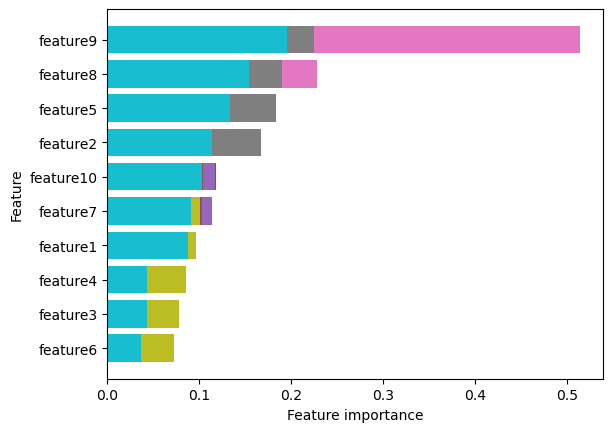

In [57]:
# cross validation 
best_params = trial.params
best_params.update({
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'num_iteration': 3000,
    'verbosity': -1,
    'early_stopping_rounds': 100,
    'importance_type': 'gain',
    'seed': 42
})

# params in modified model
best_params_mm = trial.params.copy()
best_params_mm.update({
    'objective': 'multiclass',
    'metric': 'none',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'num_iteration': 3000,
    'verbosity': -1,
    'early_stopping_rounds': 100,
    'seed': 42
})



# divide dataset
n_splits = 10
cv = list(StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 2022).split(x_gbm, y_gbm))

feature_names = [f"feature{i+1}" for i in range(x_gbm.shape[1])]
CV_names = [f"CV{i}" for i in range(n_splits)]
df_importance_GC = pd.DataFrame(columns=CV_names, index=feature_names)
df_acc = pd.DataFrame(columns=CV_names, index=['GC','SFC'])
df_importance_SFC = pd.DataFrame(columns=CV_names, index=feature_names)
df_importance_Diff = pd.DataFrame(columns=CV_names, index=feature_names)

# CV loop
for nfold, (train_index, valid_index) in enumerate(cv):
    print("-"*20, nfold, "-"*20)
    x_tr, y_tr = x_gbm[train_index], y_gbm[train_index]
    x_va, y_va = x_gbm[valid_index], y_gbm[valid_index]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    
    # define lgb dataset
    lgb_train = lgb.Dataset(x_tr, label = y_tr)
    lgb_eval = lgb.Dataset(x_va, label = y_va, reference = lgb_train)
    
    print("\n")
    print("-"*20, "GC model learning", "-"*20, "\n")
    
    
    # model training
    evaluation_results={}
    model_GC = lgb.train(best_params,
                      train_set=lgb_train,
                      valid_names=['train', 'valid'],
                      valid_sets=[lgb_train, lgb_eval],
                      evals_result=evaluation_results,
                      early_stopping_rounds = 100
                     )
    
    # calculate accuracy of test data
    y_pred_prob = model_GC.predict(x_va, num_iteration = model_GC.best_iteration)
    y_pred_GC = np.argmax(y_pred_prob,axis=1)
    acc_GC = accuracy_score(y_va, y_pred_GC)
    print("-"*20, "Test data accuracy", "-"*20, "\n")
    print(acc_GC)
    
    # gain features in normal LightGBM
    cols = list(df_10dims.drop('patient number', axis = 1).columns)
    f_importance = np.array(model_GC.feature_importance(importance_type='gain'))
    f_importance = f_importance / np.sum(f_importance)
    df_importance = pd.DataFrame({'feature':feature_names , 'importance':f_importance})
    # df_importance = df_importance.sort_values('importance', ascending=False)
    print("-"*20, "gain importance in GC", "-"*20, "\n")
    print(df_importance)
    
    # model training
    print("\n")
    print("-"*20, "SFC model learning", "-"*20, "\n")
    evaluation_results2={}
    my_mlnloss = MultiLoglossForLGBM(n_class = 3, use_softmax = True)
    model_SFC = lgb.train(best_params_mm,
                                train_set=lgb_train,
                                valid_names=['train', 'valid'],
                                valid_sets=[lgb_train, lgb_eval],
                                evals_result=evaluation_results2,
                                fobj=my_mlnloss.return_grad_and_hess,
                                feval=lambda preds, data: my_mlnloss.return_loss(preds, data),
                                early_stopping_rounds = 100
                               )
    
    # calculate accuracy of test data
    y_pred_prob_SFC = model_SFC.predict(x_va, num_iteration = model_SFC.best_iteration)
    y_pred_SFC = np.argmax(y_pred_prob_SFC,axis=1)
    acc_SFC = accuracy_score(y_va, y_pred_SFC)
    print("-"*20, "Test data accuracy", "-"*20, "\n")
    print(acc_SFC)
    
    print("-"*20, "gain importance in GC", "-"*20, "\n")
    print(df_importance)
    
    # gain features
    cols = list(df_10dims.drop('patient number', axis = 1).columns)
    f_importance_SFC = np.array(model_SFC.feature_importance(importance_type='gain'))
    f_importance_SFC = f_importance_SFC / np.sum(f_importance_SFC)
    df_importance_SFC = pd.DataFrame({'feature':feature_names, 'importance':f_importance_SFC})
    # df_importance_SFC = df_importance_SFC.sort_values('importance', ascending=False)
    print(df_importance_SFC)
    print(plot_feature_importance(df_importance_SFC))
    
    # calculate differences between GC and SFC
    f_importance_GC = np.array(model_GC.feature_importance(importance_type='gain'))
    f_importance_GC = f_importance_GC / np.sum(f_importance_GC)
    f_importance_SFC = np.array(model_SFC.feature_importance(importance_type='gain'))
    f_importance_SFC = f_importance_SFC / np.sum(f_importance_SFC)
    # after - before gain
    df_importance_subtracted = f_importance_SFC - f_importance_GC
    df_importance_subtracted = df_importance_subtracted / np.sum(np.abs(df_importance_subtracted))
    df_importance_subtracted = pd.DataFrame({'feature':feature_names , 'importance':df_importance_subtracted})
    # df_importance_subtracted = df_importance_subtracted.sort_values('importance', ascending=False)
    print("-"*20, "Difference of importance", "-"*20, "\n")
    
    print(df_importance_subtracted)
    df_acc.at['GC',CV_names[nfold]] = acc_GC
    df_acc.at['SFC',CV_names[nfold]] = acc_SFC
    df_importance_GC[CV_names[nfold]] = f_importance_SFC
    df_importance_SFC[CV_names[nfold]] = f_importance_SFC
    df_importance_Diff[CV_names[nfold]] = f_importance_SFC - f_importance_GC


In [58]:
df_acc

,CV0,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9
GC,0.545455,0.636364,0.636364,0.545455,0.727273,0.818182,0.454545,0.454545,0.8,0.5
SFC,0.545455,0.636364,0.636364,0.454545,0.727273,0.818182,0.545455,0.545455,0.8,0.5


In [59]:
 df_importance_Diff

,CV0,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9
feature1,-0.030294,-0.023715,0.001977,0.011150,0.002458,0.010100,0.000000,-0.009046,-0.006019,0.009361
feature2,0.008635,-0.006082,0.002538,0.007143,-0.008316,0.037187,0.065672,-0.005279,-0.009563,-0.005000
feature3,-0.003892,-0.011512,0.005160,-0.007882,-0.011141,-0.027868,0.000000,0.000000,0.015595,0.016772
feature4,0.000565,-0.043410,0.000111,-0.003911,-0.024643,-0.060729,0.000000,0.000000,0.009791,0.018668
feature5,0.016674,0.015039,0.001555,0.023989,-0.004001,0.014320,-0.333555,-0.052529,0.008825,0.001898
feature6,0.012402,0.001738,0.004754,-0.028035,0.002856,-0.017682,0.000000,0.011188,-0.008600,-0.013060
feature7,-0.003724,0.008545,0.010192,0.003734,0.023905,0.000620,0.000000,0.026780,0.008659,0.006297
feature8,0.001843,0.045029,-0.014173,0.005334,0.009634,0.025057,0.228017,0.058484,-0.011932,-0.024787
feature9,-0.021506,0.010672,-0.013364,-0.012757,0.003845,0.017700,-0.050662,-0.023656,-0.000247,-0.015036
feature10,0.019297,0.003696,0.001250,0.001235,0.005403,0.001296,0.090529,-0.005943,-0.006508,0.004887


In [66]:
df_importance_Diff_rank3 = pd.DataFrame(index = df_importance_Diff.index)

for col in df_acc.loc[:,(df_acc>=acc_th).sum(axis=0)==2].columns:
    rank = df_importance_Diff[col].rank(method="min" , ascending=False)
    rank3 = (rank).rank(method="min" , ascending=True)
    df_importance_Diff_rank3[col] = rank3
df_importance_Diff_rank3.loc[:,df_acc.loc[:,(df_acc>=acc_th).sum(axis=0)==2].columns]


,CV4,CV5,CV8
feature1,6.0,5.0,6.0
feature2,8.0,1.0,9.0
feature3,9.0,9.0,1.0
feature4,10.0,10.0,2.0
feature5,7.0,4.0,3.0
feature6,5.0,8.0,8.0
feature7,1.0,7.0,4.0
feature8,2.0,2.0,10.0
feature9,4.0,3.0,5.0
feature10,3.0,6.0,7.0


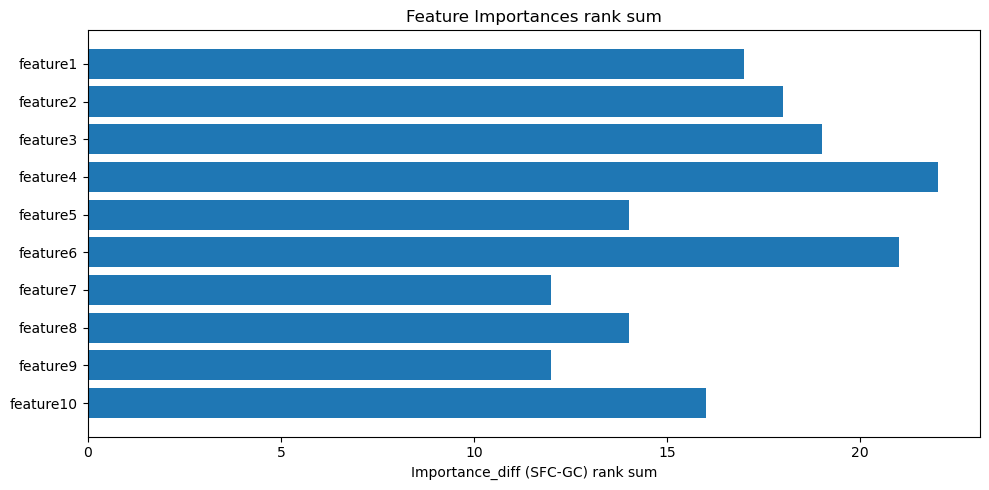

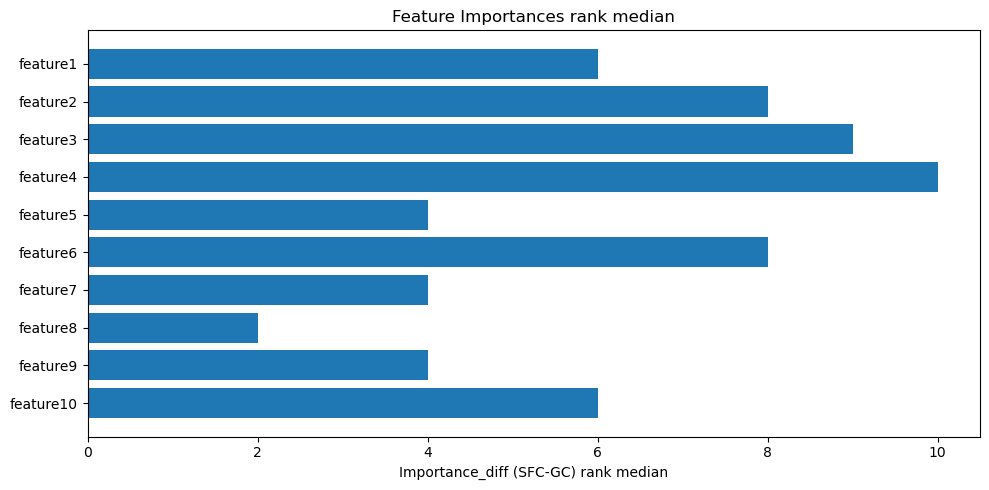

In [67]:
df_importance_Diff_rank3['rank_sum']   =df_importance_Diff_rank3.loc[:,:].sum(axis=1)
df_importance_Diff_rank3['rank_median']=df_importance_Diff_rank3.iloc[:,:-1].median(axis=1)


# high acc CV only
df_acc.loc[:,(df_acc>=acc_th).sum(axis=0)==2]

plt.figure(figsize=(10, 5))
plt.barh(feature_names, df_importance_Diff_rank3['rank_sum'])
plt.xlabel("Importance_diff (SFC-GC) rank sum")
plt.title("Feature Importances rank sum")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# high acc CV only median

plt.figure(figsize=(10, 5))
plt.barh(feature_names, df_importance_Diff_rank3['rank_median'])
plt.xlabel("Importance_diff (SFC-GC) rank median")
plt.title("Feature Importances rank median")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [88]:
df_importance_Diff_rank3.drop('rank_median',axis=1).sort_values('rank_sum').astype('int')

,CV4,CV5,CV8,rank_sum
feature7,1,7,4,12
feature9,4,3,5,12
feature5,7,4,3,14
feature8,2,2,10,14
feature10,3,6,7,16
feature1,6,5,6,17
feature2,8,1,9,18
feature3,9,9,1,19
feature6,5,8,8,21
feature4,10,10,2,22
